In [1]:
import random
import pandas as pd
import numpy as np
import cv2

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [3]:
# Define directory paths
DATASET_PATH = "/home/talal/fyp/deep project/archive_2/"

TRAIN_DIR = DATASET_PATH + 'train'
VAL_DIR = DATASET_PATH + 'val'
TEST_DIR = DATASET_PATH + 'test'

TRAIN_CSV = DATASET_PATH + 'train.csv'
VAL_CSV = DATASET_PATH + 'val.csv'
TEST_CSV = DATASET_PATH + 'test.csv'

In [4]:
# Load csv files
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

In [5]:
train_df

,clip_name,clip_path,label
0,v_Swing_g05_c02,/train/Swing/v_Swing_g05_c02.avi,Swing
1,v_Swing_g21_c03,/train/Swing/v_Swing_g21_c03.avi,Swing
2,v_Swing_g07_c01,/train/Swing/v_Swing_g07_c01.avi,Swing
3,v_Swing_g24_c04,/train/Swing/v_Swing_g24_c04.avi,Swing
4,v_Swing_g20_c03,/train/Swing/v_Swing_g20_c03.avi,Swing
...,...,...,...
10050,v_Diving_g09_c03,/train/Diving/v_Diving_g09_c03.avi,Diving
10051,v_Diving_g12_c05,/train/Diving/v_Diving_g12_c05.avi,Diving
10052,v_Diving_g18_c02,/train/Diving/v_Diving_g18_c02.avi,Diving
10053,v_Diving_g23_c06,/train/Diving/v_Diving_g23_c06.avi,Diving


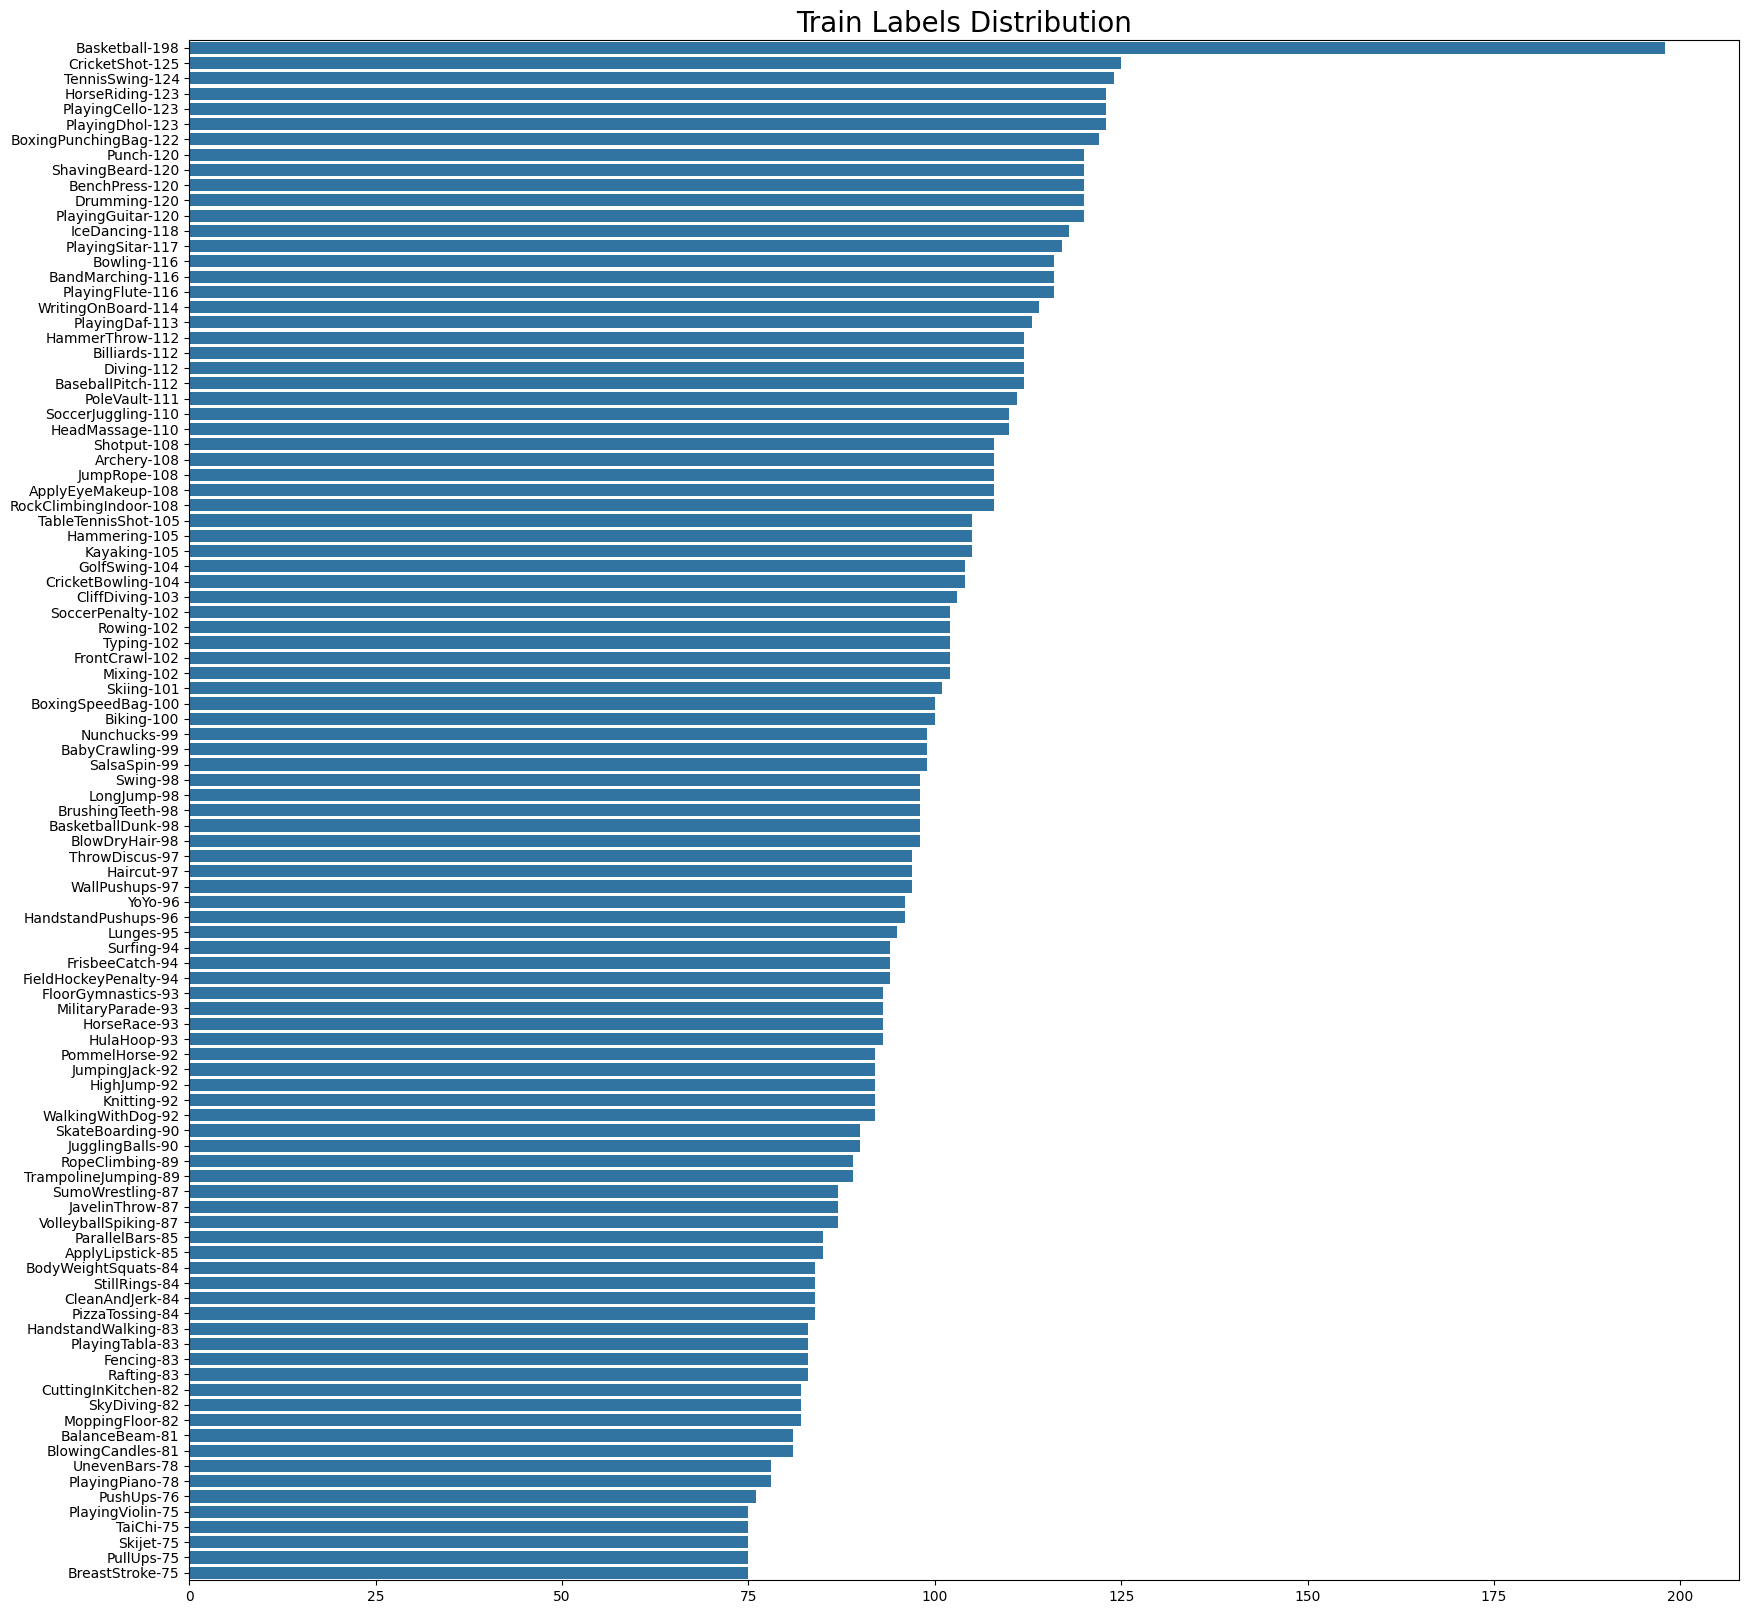

In [6]:
# View Label Distibutions
plt.figure(figsize=(20, 20))
plt.title('Train Labels Distribution', fontsize=20)
label_distribution = train_df['label'].value_counts()

sns.barplot(x=label_distribution.values,
            y=list(label_distribution.keys() + "-" + label_distribution.values.astype(str)),
            orient="h");

In [7]:
# Define labels list
PENTA_LABELS = ['BenchPress', 'Drumming', 'HorseRiding', 'Basketball', 'TennisSwing']


In [5]:
# Get selected action label rows from dataframes
# Define labels list
PENTA_LABELS = ['BenchPress', 'Drumming', 'HorseRiding', 'Basketball', 'TennisSwing']
train_penta_df = train_df[train_df['label'].isin(PENTA_LABELS)]
val_penta_df = val_df[val_df['label'].isin(PENTA_LABELS)]
test_penta_df = test_df[test_df['label'].isin(PENTA_LABELS)]

In [6]:
# Count labels in training set
train_counts = train_penta_df['label'].value_counts()
print("Training set counts:")
print(train_counts)

# Count labels in validation set
val_counts = val_penta_df['label'].value_counts()
print("\nValidation set counts:")
print(val_counts)

# Count labels in test set
test_counts = test_penta_df['label'].value_counts()
print("\nTest set counts:")
print(test_counts)

Training set counts:
label
Basketball     198
TennisSwing    124
HorseRiding    123
BenchPress     120
Drumming       120
Name: count, dtype: int64

Validation set counts:
label
Basketball     33
TennisSwing    21
BenchPress     20
HorseRiding    20
Drumming       20
Name: count, dtype: int64

Test set counts:
label
Basketball     34
HorseRiding    21
TennisSwing    21
Drumming       21
BenchPress     20
Name: count, dtype: int64


In [7]:
# Training set balancing
train_counts = train_penta_df['label'].value_counts()
train_min = train_counts.min()
balanced_train_df = pd.concat([
    train_penta_df[train_penta_df['label'] == label].sample(n=train_min, random_state=42)
    for label in PENTA_LABELS
])

# Validation set balancing
val_counts = val_penta_df['label'].value_counts()
val_min = val_counts.min()
balanced_val_df = pd.concat([
    val_penta_df[val_penta_df['label'] == label].sample(n=val_min, random_state=42)
    for label in PENTA_LABELS
])

# Test set balancing
test_counts = test_penta_df['label'].value_counts()
test_min = test_counts.min()
balanced_test_df = pd.concat([
    test_penta_df[test_penta_df['label'] == label].sample(n=test_min, random_state=42)
    for label in PENTA_LABELS
])

# Print counts to verify
print("Original counts:")
print("\nTraining:", train_counts)
print("\nValidation:", val_counts)
# print("\nTest:", test_counts)

print("\nBalanced counts:")
print("\nTraining:", balanced_train_df['label'].value_counts())
print("\nValidation:", balanced_val_df['label'].value_counts())
# print("\nTest:", balanced_test_df['label'].value_counts())

Original counts:

Training: label
Basketball     198
TennisSwing    124
HorseRiding    123
BenchPress     120
Drumming       120
Name: count, dtype: int64

Validation: label
Basketball     33
TennisSwing    21
BenchPress     20
HorseRiding    20
Drumming       20
Name: count, dtype: int64

Balanced counts:

Training: label
BenchPress     120
Drumming       120
HorseRiding    120
Basketball     120
TennisSwing    120
Name: count, dtype: int64

Validation: label
BenchPress     20
Drumming       20
HorseRiding    20
Basketball     20
TennisSwing    20
Name: count, dtype: int64


In [8]:
# Reset indices and shuffle dataframes
train_penta_df = train_penta_df.sample(frac=1.0).reset_index(drop=True)
val_penta_df = val_penta_df.sample(frac=1.0).reset_index(drop=True)
test_penta_df = test_penta_df.sample(frac=1.0).reset_index(drop=True)

In [9]:
# Attach full path to clip_path column
train_penta_df['clip_path'] = train_penta_df['clip_path'].apply(lambda path: DATASET_PATH[:-1] + path)
val_penta_df['clip_path'] = val_penta_df['clip_path'].apply(lambda path: DATASET_PATH[:-1] + path)
test_penta_df['clip_path'] = test_penta_df['clip_path'].apply(lambda path: DATASET_PATH[:-1] + path)

In [13]:
test_penta_df

,clip_name,clip_path,label
0,v_Basketball_g12_c01,/home/talal/fyp/deep project/archive_2/test/Ba...,Basketball
1,v_BenchPress_g12_c02,/home/talal/fyp/deep project/archive_2/test/Be...,BenchPress
2,v_BasketballDunk_g05_c06,/home/talal/fyp/deep project/archive_2/test/Ba...,Basketball
3,v_TennisSwing_g09_c05,/home/talal/fyp/deep project/archive_2/test/Te...,TennisSwing
4,v_BasketballDunk_g25_c02,/home/talal/fyp/deep project/archive_2/test/Ba...,Basketball
...,...,...,...
112,v_HorseRiding_g12_c05,/home/talal/fyp/deep project/archive_2/test/Ho...,HorseRiding
113,v_HorseRiding_g09_c03,/home/talal/fyp/deep project/archive_2/test/Ho...,HorseRiding
114,v_Drumming_g18_c03,/home/talal/fyp/deep project/archive_2/test/Dr...,Drumming
115,v_Drumming_g03_c02,/home/talal/fyp/deep project/archive_2/test/Dr...,Drumming


In [14]:
train_penta_df=train_penta_df
val_penta_df=val_penta_df
#test_penta_df=test_penta_df

In [10]:
def load_video_frames(video_path, frame_step=1, frame_count=10):
    """
    Load frames from a video with a specified frame step and number of frames.
    If the video doesn't have enough frames, generate black frames to fill the remainder.
    
    Args:
        video_path (str): Path to the video file.
        frame_step (int): Step to skip frames. Defaults to 1 (no skipping).
        frame_count (int): Number of frames to load. Defaults to 10.
    
    Returns:
        list: List of video frames (in RGB format).
    """
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_idx = 0

    while cap.isOpened() and len(frames) < frame_count:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % frame_step == 0:
            # Convert frame from BGR (OpenCV format) to RGB (Matplotlib format)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        frame_idx += 1

    cap.release()

    # Get image widht, height and channels in a tuple
    img_shape = frames[0].shape

    # Generate black frames if needed
    while len(frames) < frame_count:
        black_frame = np.zeros(img_shape, dtype=np.uint8)  # 240x320 black RGB frame
        frames.append(black_frame)

    return frames

In [11]:
def view_frames(frames, frame_step=1):
    """
    Display frames in a grid layout with frame number and frame step in the title.
    
    Args:
        frames (list): List of frames to display.
        frame_step (int): Frame step used for loading the frames.
    """
    n = len(frames)  # Total number of frames
    rows = n // 5
    if n % 5 > 0:
        rows += 1

    plt.figure(figsize=(18, 8))
    for idx, frame in enumerate(frames):
        plt.subplot(rows, 5, idx + 1)
        plt.title(f"Frame #{idx * frame_step + 1}")
        plt.axis("off")
        plt.imshow(frame)
    plt.show()

In [17]:
# Select a random sample from the training set
sample_path = random.sample(train_penta_df['clip_path'].to_list(), 1)[0]

# Print the sample path
print(f"Sample path: {sample_path}")

# Load frames from the sample video
frame_step = 15
sample_video = load_video_frames(sample_path, frame_step=frame_step, frame_count=10)

Sample path: /home/talal/fyp/deep project/archive_2/train/HorseRiding/v_HorseRiding_g04_c05.avi


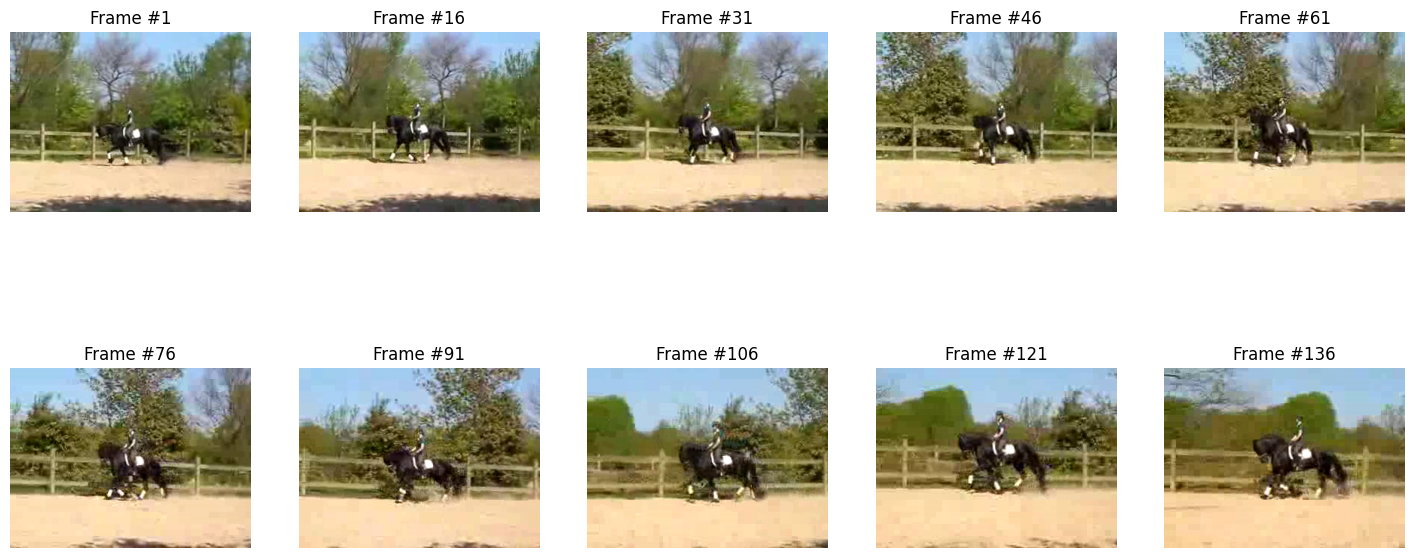

In [18]:
# Display the frames
view_frames(sample_video, frame_step=frame_step)

In [19]:
from torch.utils.data import Dataset, DataLoader

In [20]:
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
from torchvision import transforms

class VideoDataset(Dataset):
    def __init__(self, dataframe, input_frames=10, output_frames=5, stride=3, frame_size=(64, 64), transform=None, color_mode='grayscale'):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing video file paths.
            input_frames (int): Number of input frames.
            output_frames (int): Number of output frames to predict.
            stride (int): Number of frames to skip between sequences.
            frame_size (tuple): Tuple specifying frame width and height (e.g., (64, 64)).
            transform (callable, optional): Optional transform to be applied on a sample.
            color_mode (str): 'grayscale' or 'rgb'.
        """
        self.input_frames = input_frames
        self.output_frames = output_frames
        self.sequence_length = self.input_frames + self.output_frames
        self.stride = stride
        self.transform = transform
        self.color_mode = color_mode.lower()
        self.frame_size = frame_size
        self.sequences = []  # List to store sequence information
        self.cached_video = None  # Cache for the currently loaded video
        self.cached_video_path = None  # Path of the cached video

        if self.color_mode not in ['grayscale', 'rgb']:
            raise ValueError("color_mode must be either 'grayscale' or 'rgb'")

        # Build the sequences list
        for idx, row in dataframe.iterrows():
            video_path = row['clip_path']
            total_frames = self.get_total_frames(video_path)

            if total_frames < self.sequence_length:
                total_sequences = 1  # We'll augment frames later
            else:
                # Calculate the number of sequences with the given stride
                total_sequences = (total_frames - self.sequence_length) // self.stride + 1

            for seq_idx in range(total_sequences):
                start_idx = seq_idx * self.stride
                self.sequences.append({
                    'video_path': video_path,
                    'start_idx': start_idx,
                    'total_frames': total_frames
                })

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence_info = self.sequences[idx]
        video_path = sequence_info['video_path']
        start_idx = sequence_info['start_idx']
        
        # Check if the video is already cached
        if self.cached_video_path != video_path:
            self.cached_video = self.load_video(video_path)
            self.cached_video_path = video_path

        # Extract frames for the sequence
        end_idx = start_idx + self.sequence_length
        frames = self.cached_video[start_idx:end_idx]

        # Handle cases where frames are missing
        if len(frames) < self.sequence_length:
            frames = self.augment_frames(frames, self.sequence_length)

        # Split into input and target sequences
        input_seq = frames[:self.input_frames]
        target_seq = frames[self.input_frames:]

        # Convert to numpy arrays if not already
        input_seq = np.array(input_seq)
        target_seq = np.array(target_seq)

        # Add channel dimension for grayscale
        if self.color_mode == 'grayscale':
            if input_seq.ndim == 3:
                input_seq = input_seq[..., np.newaxis]
            if target_seq.ndim == 3:
                target_seq = target_seq[..., np.newaxis]

        # Convert to tensors and normalize to [0, 1]
        input_seq = torch.from_numpy(input_seq).float() / 255.0
        target_seq = torch.from_numpy(target_seq).float() / 255.0

        # Ensure dimensions are [frames, channels, height, width]
        if self.color_mode == 'grayscale':
            input_seq = input_seq.permute(0, 3, 1, 2)
            target_seq = target_seq.permute(0, 3, 1, 2)
        else:  # RGB mode
            input_seq = input_seq.permute(0, 3, 1, 2)
            target_seq = target_seq.permute(0, 3, 1, 2)

        if self.transform:
            input_seq = self.transform(input_seq)
            target_seq = self.transform(target_seq)

        return {'input': input_seq, 'target': target_seq}

    def load_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.resize(frame, self.frame_size)
            if self.color_mode == 'grayscale':
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames.append(frame)
        cap.release()
        return np.array(frames)

    def augment_frames(self, frames, required_length):
        """Augment frames to reach the required sequence length."""
        frames = np.array(frames)
        current_length = len(frames)
        deficit = required_length - current_length

        if len(frames) > 0:
            last_frame = frames[-1]
        else:
            if self.color_mode == 'grayscale':
                last_frame = np.zeros((self.frame_size[1], self.frame_size[0]), dtype=np.uint8)
            else:
                last_frame = np.zeros((self.frame_size[1], self.frame_size[0], 3), dtype=np.uint8)

        if self.color_mode == 'grayscale' and last_frame.ndim == 2:
            last_frame = last_frame[..., np.newaxis]

        repeated_frames = np.repeat(last_frame[np.newaxis, ...], deficit, axis=0)
        
        if frames.ndim < repeated_frames.ndim:
            frames = frames[..., np.newaxis]
            
        augmented_frames = np.concatenate([frames, repeated_frames], axis=0)
        return augmented_frames

    def get_total_frames(self, video_path):
        """Get the total number of frames in a video."""
        cap = cv2.VideoCapture(video_path)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.release()
        return total_frames


In [21]:
# Parameters
batch_size = 8                 # Number of sequences per batch
color_mode = 'rgb'              # or 'grayscale'
input_frames = 10               # Number of input frames
output_frames = 5               # Number of frames to predict
stride = 6                      # 5 frame skip between sequences
frame_size = (64, 64)           # Resize frames to 64x64
num_workers = 12                # Number of DataLoader workers

In [22]:
import torchvision.transforms as transforms

# Define the normalization transform
if color_mode == 'grayscale':
    transform = transforms.Compose([
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
else:
    transform = transforms.Compose([
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])


In [23]:
# Create datasets
train_dataset = VideoDataset(
    train_penta_df, 
    input_frames=input_frames,
    output_frames=output_frames,
    stride=stride,
    frame_size=frame_size,
    transform=transform,
    color_mode=color_mode
)

val_dataset = VideoDataset(
    val_penta_df,
    input_frames=input_frames,
    output_frames=output_frames,
    stride=stride,
    frame_size=frame_size,
    transform=transform,
    color_mode=color_mode
)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

test_dataset = VideoDataset(
    test_penta_df,  # Your test dataframe
    input_frames=input_frames,
    output_frames=output_frames,
    stride=stride,
    frame_size=frame_size,
    transform=transform,
    color_mode=color_mode
)

# Create test loader
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

In [24]:
# Print total number of batches
print(f"Total train batches: {len(train_loader)}")

# Print total number of sequences
print(f"Total train sequences: {len(train_dataset)}")

# Print total number of frames
print(f"Total train frames: {len(train_dataset) * train_dataset.sequence_length}")


Total train batches: 2204
Total train sequences: 17628
Total train frames: 264420


In [25]:
# Fetch a batch
for batch in train_loader:
    input_seq = batch['input']  # Shape: [batch_size, input_frames, channels, height, width]
    target_seq = batch['target']  # Shape: [batch_size, output_frames, channels, height, width]

    print(f"Input sequence shape: {input_seq.shape}")
    print(f"Target sequence shape: {target_seq.shape}")

    # Break after first batch
    break

Input sequence shape: torch.Size([8, 10, 3, 64, 64])
Target sequence shape: torch.Size([8, 5, 3, 64, 64])


In [13]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from pytorch_msssim import ssim

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class VideoTransformer(pl.LightningModule):
    def __init__(self, input_channels=1, d_model=256, nhead=8, num_layers=6,
                 dim_feedforward=1024, input_frames=10, output_frames=5):
        super().__init__()
        
        self.input_frames = input_frames
        self.output_frames = output_frames
        self.d_model = d_model
        
        # CNN Encoder for each frame
        self.frame_encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, d_model, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=0.1,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Transformer Decoder
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=0.1,
            batch_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        # Frame Decoder (CNN)
        self.frame_decoder = nn.Sequential(
            nn.ConvTranspose2d(d_model, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, input_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
        self.save_hyperparameters()

    def encode_frames(self, x):
        # x shape: [batch, frames, channels, height, width]
        batch_size, seq_len = x.shape[0], x.shape[1]
        
        # Encode each frame
        encoded_frames = []
        for i in range(seq_len):
            encoded = self.frame_encoder(x[:, i])  # [batch, d_model, h', w']
            h, w = encoded.shape[-2:]
            encoded = encoded.flatten(2).transpose(1, 2)  # [batch, h'*w', d_model]
            encoded_frames.append(encoded)
        
        encoded_sequence = torch.stack(encoded_frames, dim=1)  # [batch, seq_len, h'*w', d_model]
        return encoded_sequence, (h, w)

    def forward(self, x):
        # Encode input frames
        encoded_sequence, (h, w) = self.encode_frames(x)  # [batch, seq_len, h'*w', d_model]
        batch_size = encoded_sequence.shape[0]
        
        # Reshape for transformer
        encoded_sequence = encoded_sequence.flatten(1, 2)  # [batch, seq_len*h'*w', d_model]
        
        # Add positional encoding
        encoded_sequence = self.pos_encoder(encoded_sequence)
        
        # Transformer encoder
        memory = self.transformer_encoder(encoded_sequence)
        
        # Generate decoder input (start tokens)
        decoder_input = torch.zeros(
            batch_size,
            self.output_frames * h * w,
            self.d_model,
            device=x.device
        )
        decoder_input = self.pos_encoder(decoder_input)
        
        # Transformer decoder
        output = self.transformer_decoder(decoder_input, memory)
        
        # Reshape output and decode frames
        output = output.view(batch_size, self.output_frames, h * w, self.d_model)
        
        predicted_frames = []
        for i in range(self.output_frames):
            current = output[:, i].view(batch_size, h, w, self.d_model)
            current = current.permute(0, 3, 1, 2)
            decoded = self.frame_decoder(current)
            predicted_frames.append(decoded)
        
        # Stack predictions
        predictions = torch.stack(predicted_frames, dim=1)
        return predictions

    def calculate_metrics(self, pred, target):
        """Calculate MSE and SSIM metrics"""
        mse = F.mse_loss(pred, target)
        ssim_val = ssim(pred, target, data_range=1.0)
        return mse, ssim_val

    def training_step(self, batch, batch_idx):
        input_seq = batch['input']
        target_seq = batch['target']
        
        predictions = self(input_seq)
        mse_loss, ssim_val = self.calculate_metrics(predictions, target_seq)
        
        self.log('train_mse', mse_loss, prog_bar=True)
        self.log('train_ssim', ssim_val, prog_bar=True)
        
        return mse_loss

    def validation_step(self, batch, batch_idx):
        input_seq = batch['input']
        target_seq = batch['target']
        
        predictions = self(input_seq)
        mse_loss, ssim_val = self.calculate_metrics(predictions, target_seq)
        
        self.log('val_mse', mse_loss, prog_bar=True)
        self.log('val_ssim', ssim_val, prog_bar=True)
        
        return mse_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.5,
            patience=5,
            verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": scheduler,
            "monitor": "val_mse"
        }



In [27]:
# Training function
def train_transformer(train_loader, val_loader, max_epochs=100):
    model = VideoTransformer(
        input_channels=3,  # Change to 3 for RGB
        d_model=256,
        nhead=8,
        num_layers=6,
        dim_feedforward=1024,
        input_frames=10,
        output_frames=5
    )
    
    trainer = pl.Trainer(
        max_epochs=max_epochs,
        accelerator='gpu' if torch.cuda.is_available() else 'cpu',
        devices=1,
        logger=pl.loggers.TensorBoardLogger('lightning_logs/'),
        callbacks=[
            pl.callbacks.ModelCheckpoint(
                monitor='val_mse',
                dirpath='checkpoints/',
                filename='transformer-{epoch:02d}-{val_mse:.4f}',
                save_top_k=3,
                mode='min'
            ),
            pl.callbacks.EarlyStopping(
                monitor='val_mse',
                patience=10,
                mode='min'
            )
        ],
    )
    
    trainer.fit(model, train_loader, val_loader)
    return model
if __name__ == "__main__":
    # Train the model
    model = train_transformer(train_loader, val_loader, max_epochs=5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2024-12-03 21:08:56.429709: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-03 21:08:56.927839: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/talal/fyp/venv/lib/python3.12/site-packages/pytorch_msssim/ssim.py:50: UserWarning: Skipping Gaussian Smoothing at dimension 2+0 for input: torch.Size([8, 5, 3, 64, 64]) and win size: 11
  warnings.warn(


Epoch 0: 100%|██████████| 2204/2204 [11:37<00:00,  3.16it/s, v_num=81, train_mse=0.445, train_ssim=0.000766]

/home/talal/fyp/venv/lib/python3.12/site-packages/pytorch_msssim/ssim.py:50: UserWarning: Skipping Gaussian Smoothing at dimension 2+0 for input: torch.Size([4, 5, 3, 64, 64]) and win size: 11
  warnings.warn(


Epoch 0: 100%|██████████| 2204/2204 [12:10<00:00,  3.02it/s, v_num=81, train_mse=0.445, train_ssim=0.000766, val_mse=0.356, val_ssim=0.00124]

/home/talal/fyp/venv/lib/python3.12/site-packages/pytorch_msssim/ssim.py:50: UserWarning: Skipping Gaussian Smoothing at dimension 2+0 for input: torch.Size([1, 5, 3, 64, 64]) and win size: 11
  warnings.warn(


Epoch 4: 100%|██████████| 2204/2204 [12:22<00:00,  2.97it/s, v_num=81, train_mse=0.410, train_ssim=0.00028, val_mse=0.356, val_ssim=0.00124] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 2204/2204 [12:23<00:00,  2.97it/s, v_num=81, train_mse=0.410, train_ssim=0.00028, val_mse=0.356, val_ssim=0.00124]


In [ ]:
def test_model_on_dataset(model_path, test_df, mode='grayscale', num_input_frames=10, num_pred_frames=5):
    """
    Test model on all videos in the DataFrame and calculate average metrics.
    
    Args:
        model_path: Path to model checkpoint
        test_df: DataFrame containing video paths
        mode: 'grayscale' or 'rgb'
        num_input_frames: Number of input frames
        num_pred_frames: Number of frames to predict
    """
    # Initialize model
    input_channels = 1 if mode == 'grayscale' else 3
    model = VideoTransformer(
        input_channels=3, 
        d_model=256,
        nhead=8,
        num_layers=6,
        dim_feedforward=1024,
        input_frames=10,
        output_frames=5
    )
    
    
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location='cpu')
    model.load_state_dict(checkpoint['state_dict'], strict=True)
    model.eval()
    model.to('cuda' if torch.cuda.is_available() else 'cpu')

    all_metrics = {
        'video_name': [],
        'label': [],
        'mse': [],
        'ssim': []
    }
    
    def load_and_preprocess_video(video_path, total_frames=15):
        cap = cv2.VideoCapture(video_path)
        frames = []
        while len(frames) < total_frames:
            ret, frame = cap.read()
            if not ret:
                break
                
            if mode == 'grayscale':
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
            resized = cv2.resize(frame, (64, 64))
            frames.append(resized)
        cap.release()
        
        if len(frames) < total_frames:
            last_frame = frames[-1] if frames else np.zeros((64, 64, 3 if mode == 'rgb' else 1), dtype=np.uint8)
            while len(frames) < total_frames:
                frames.append(last_frame.copy())
                
        frames = np.array(frames)
        if mode == 'grayscale' and frames.ndim == 3:
            frames = frames[..., np.newaxis]
            
        frames = torch.from_numpy(frames).float() / 255.0
        if mode == 'grayscale':
            frames = frames.permute(0, 3, 1, 2)
        else:
            frames = frames.permute(0, 3, 1, 2)
            
        return frames

    print("\nTesting model on dataset...")
    print(f"Total videos to process: {len(test_df)}")
    
    for idx, row in test_df.iterrows():
        try:
            video_path = row['clip_path']
            video_name = row['clip_name']
            label = row['label']
            
            print(f"\nProcessing {idx+1}/{len(test_df)}: {video_name} ({label})")
            
            # Load and preprocess video
            all_frames = load_and_preprocess_video(video_path)
            
            # Split into input and ground truth
            input_frames = all_frames[:num_input_frames].unsqueeze(0)
            ground_truth = all_frames[num_input_frames:num_input_frames+num_pred_frames].unsqueeze(0)
            
            # Generate predictions
            with torch.no_grad():
                input_frames = input_frames.to(model.device)
                ground_truth = ground_truth.to(model.device)
                predicted_frames = model(input_frames)
                
                # Calculate metrics
                mse = F.mse_loss(predicted_frames, ground_truth).item()
                ssim_val = ssim(predicted_frames, ground_truth, data_range=1.0).item()
                
                # Store metrics
                all_metrics['video_name'].append(video_name)
                all_metrics['label'].append(label)
                all_metrics['mse'].append(mse)
                all_metrics['ssim'].append(ssim_val)
                
                print(f"MSE: {mse:.4f}, SSIM: {ssim_val:.4f}")
                
        except Exception as e:
            print(f"Error processing video {video_name}: {str(e)}")
            continue
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(all_metrics)
    
    # Calculate overall statistics
    print("\n=== Overall Results ===")
    print(f"Total videos processed: {len(results_df)}")
    print("\nMetrics by class:")
    class_metrics = results_df.groupby('label').agg({
        'mse': ['mean', 'std'],
        'ssim': ['mean', 'std']
    })
    print(class_metrics)
    
    print("\nOverall metrics:")
    print(f"Average MSE: {results_df['mse'].mean():.4f} ± {results_df['mse'].std():.4f}")
    print(f"Average SSIM: {results_df['ssim'].mean():.4f} ± {results_df['ssim'].std():.4f}")
    
    # Save results to CSV
    results_path = 'test_results.csv'
    results_df.to_csv(results_path, index=False)
    print(f"\nDetailed results saved to: {results_path}")
    
    return results_df


if __name__ == "__main__":
    model_path = "checkpoints/transformer-epoch=04-val_mse=0.3555.ckpt"
    
    try:
        # Test the model
        results = test_model_on_dataset(
            model_path=model_path,
            test_df=test_penta_df,  
            mode='rgb',  # or 'grayscale'
            num_input_frames=10,
            num_pred_frames=5
        )
        
    except Exception as e:
        print(f"Error during execution: {str(e)}")
        raise e

/tmp/ipykernel_1116787/1187683552.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location='cpu')



Testing model on dataset...
Total videos to process: 117

Processing 1/117: v_Drumming_g03_c03 (Drumming)
MSE: 0.0776, SSIM: 0.0119

Processing 2/117: v_TennisSwing_g01_c06 (TennisSwing)
MSE: 0.2445, SSIM: 0.0004

Processing 3/117: v_Basketball_g12_c01 (Basketball)
MSE: 0.3603, SSIM: 0.0066

Processing 4/117: v_BenchPress_g02_c03 (BenchPress)
MSE: 0.2679, SSIM: 0.0002

Processing 5/117: v_TennisSwing_g24_c01 (TennisSwing)
MSE: 0.2152, SSIM: 0.0006

Processing 6/117: v_HorseRiding_g12_c02 (HorseRiding)
MSE: 0.4907, SSIM: 0.0001

Processing 7/117: v_TennisSwing_g18_c05 (TennisSwing)
MSE: 0.1903, SSIM: 0.0005

Processing 8/117: v_Basketball_g24_c02 (Basketball)
MSE: 0.0878, SSIM: 0.0272

Processing 9/117: v_Drumming_g23_c05 (Drumming)
MSE: 0.0846, SSIM: 0.0122

Processing 10/117: v_Drumming_g11_c02 (Drumming)
MSE: 0.3301, SSIM: 0.0004

Processing 11/117: v_Drumming_g25_c01 (Drumming)
MSE: 0.3116, SSIM: 0.0003

Processing 12/117: v_BasketballDunk_g25_c02 (Basketball)
MSE: 0.1529, SSIM: 0.


Processing video: archive_2/train/BenchPress/v_BenchPress_g13_c07.avi


/tmp/ipykernel_1116787/4017454200.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location='cpu')
/home/talal/fyp/venv/lib/pytho

First Iteration MSE: 0.1390
First Iteration SSIM: 0.0044


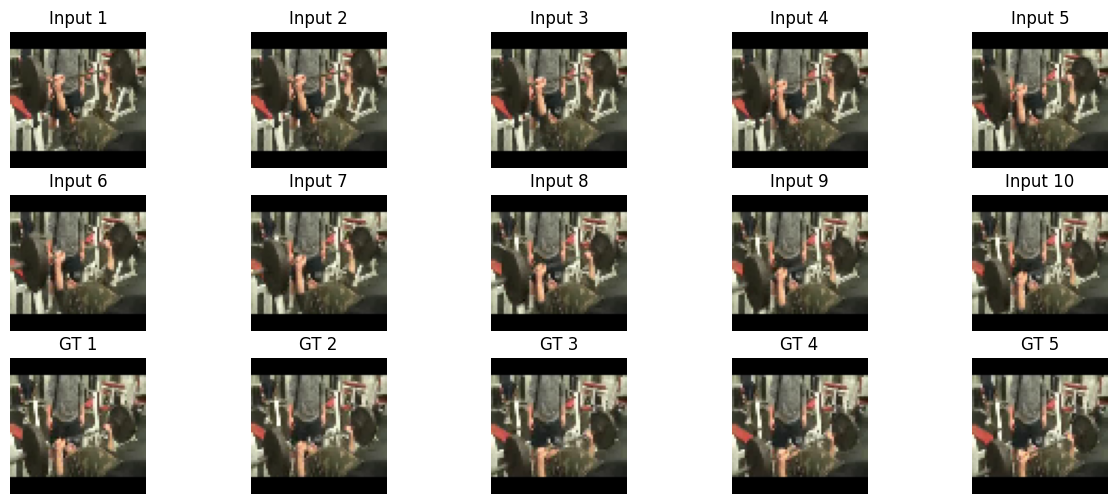

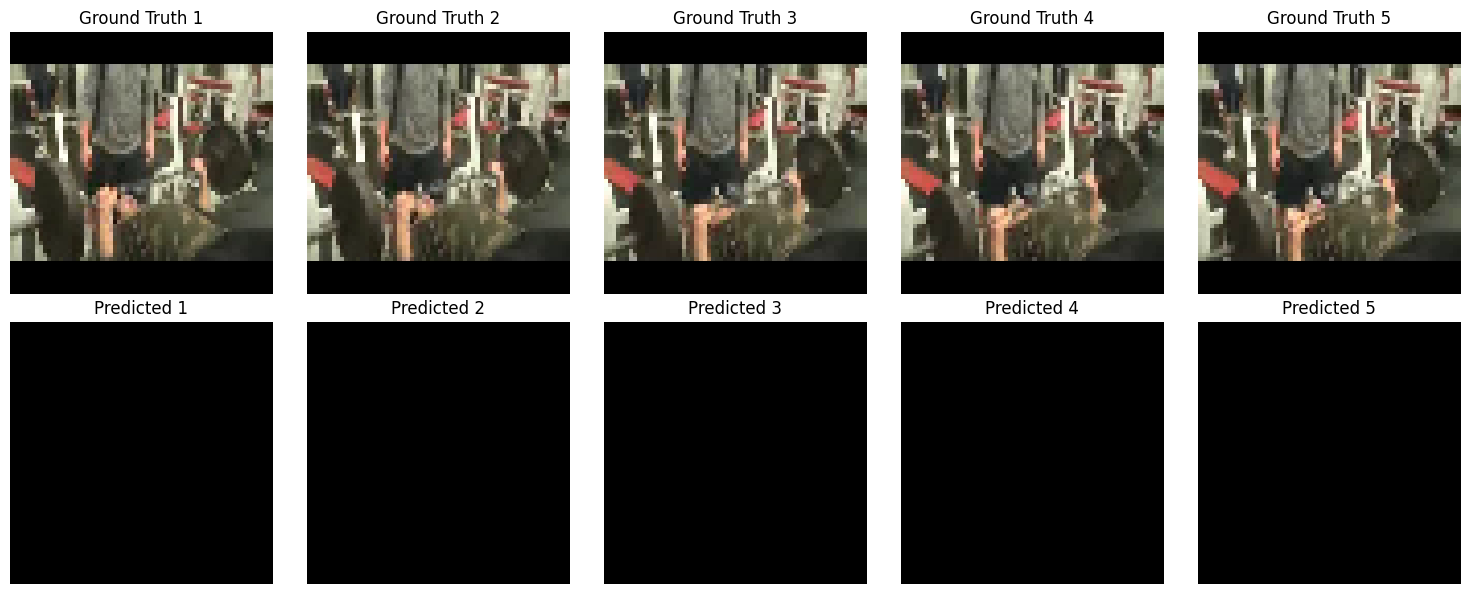

Video saved to: archive_2/train/BenchPress/v_BenchPress_g13_c07_predicted.mp4


In [ ]:
def test_prediction_sequence(model_path, video_path, output_path, num_input_frames=10, num_pred_frames=5, mode='grayscale'):
    """
    Test prediction by creating a sequence of predictions and save as video.
    """

    input_channels = 1 if mode == 'grayscale' else 3
    model = VideoTransformer(
        input_channels=3, 
        d_model=256,
        nhead=8,
        num_layers=6,
        dim_feedforward=1024,
        input_frames=10,
        output_frames=5
    )
    checkpoint = torch.load(model_path, map_location='cpu')
    model.load_state_dict(checkpoint['state_dict'], strict=True)
    model.eval()
    model.to('cuda' if torch.cuda.is_available() else 'cpu')
    
    def load_video_frames(video_path, frame_size=(64, 64)):
        cap = cv2.VideoCapture(video_path)
        frames = []
        fps = cap.get(cv2.CAP_PROP_FPS)
        while True:
            ret, frame = cap.read()
            if not ret:
                break
                
            if mode == 'grayscale':
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            else:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                
            resized = cv2.resize(frame, frame_size)
            frames.append(resized)
        cap.release()
        return np.array(frames), fps

    def preprocess_frames(frames):
        if mode == 'grayscale':
            frames = frames[..., np.newaxis]
        
        frames = torch.from_numpy(frames).float() / 255.0
        if mode == 'grayscale':
            frames = frames.permute(0, 3, 1, 2)
        else:
            frames = frames.permute(0, 3, 1, 2)
        
        return frames.unsqueeze(0)

    # Load all frames
    all_frames, original_fps = load_video_frames(video_path)
    total_frames = len(all_frames)
    
    # Create video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    frame_size = all_frames[0].shape[:2]
    out = cv2.VideoWriter(output_path, fourcc, original_fps, (frame_size[1], frame_size[0]), mode != 'grayscale')
    
    # Process video in chunks and save frames
    start_idx = 0
    first_iteration = True
    
    while start_idx + num_input_frames < total_frames:
        # Get input frames
        input_frames = all_frames[start_idx:start_idx + num_input_frames]
        
        # Get ground truth for metrics
        end_idx = min(start_idx + num_input_frames + num_pred_frames, total_frames)
        ground_truth = all_frames[start_idx + num_input_frames:end_idx]
        
        if len(ground_truth) < num_pred_frames:
            break
            
        # Preprocess frames
        input_tensor = preprocess_frames(input_frames)
        ground_truth_tensor = preprocess_frames(ground_truth)
        
        # Make prediction
        with torch.no_grad():
            input_tensor = input_tensor.to(model.device)
            predicted_frames = model(input_tensor)
        
        # Convert predictions to numpy arrays
        pred_frames = predicted_frames[0].cpu().numpy().transpose(0, 2, 3, 1)
        
        # Write original frames to video
        for frame in input_frames:
            if mode == 'grayscale':
                frame_bgr = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
            else:
                frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write((frame_bgr * 255).astype(np.uint8))
        
        # Write predicted frames to video
        for frame in pred_frames:
            if mode == 'grayscale':
                frame = frame.squeeze()
                frame_bgr = cv2.cvtColor((frame * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
            else:
                frame_bgr = cv2.cvtColor((frame * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
            out.write(frame_bgr)
        
      
        if first_iteration:
            mse = F.mse_loss(predicted_frames, ground_truth_tensor.to(model.device))
            ssim_val = ssim(predicted_frames, ground_truth_tensor.to(model.device), data_range=1.0)
            
            print(f"First Iteration MSE: {mse.item():.4f}")
            print(f"First Iteration SSIM: {ssim_val.item():.4f}")
            
           
            plt.figure(figsize=(15, 6))
            for i in range(num_input_frames + num_pred_frames):
                plt.subplot(3, 5, i+1)
                if mode == 'grayscale':
                    plt.imshow(all_frames[i], cmap='gray')
                else:
                    plt.imshow(all_frames[i])
                if i < num_input_frames:
                    plt.title(f'Input {i+1}')
                else:
                    plt.title(f'GT {i-num_input_frames+1}')
                plt.axis('off')
            
            plt.figure(figsize=(15, 6))
            for i in range(num_pred_frames):
                plt.subplot(2, 5, i+1)
                if mode == 'grayscale':
                    plt.imshow(ground_truth[i], cmap='gray')
                else:
                    plt.imshow(ground_truth[i])
                plt.title(f'Ground Truth {i+1}')
                plt.axis('off')
                
                plt.subplot(2, 5, i+6)
                if mode == 'grayscale':
                    plt.imshow(pred_frames[i].squeeze(), cmap='gray')
                else:
                    plt.imshow(pred_frames[i])
                plt.title(f'Predicted {i+1}')
                plt.axis('off')
            
            plt.tight_layout()
            plt.show()
            
            first_iteration = False
        
        # Move to next chunk
        start_idx += num_input_frames + num_pred_frames
    
    # Release video writer
    out.release()
    print(f"Video saved to: {output_path}")


if __name__ == "__main__":
    model_path = "models/transformer-epoch=04-val_mse=0.3555.ckpt"
    test_videos = [
        "archive_2/train/BenchPress/v_BenchPress_g13_c07.avi",
    ]
    
    try:
        for video_path in test_videos:
            print(f"\nProcessing video: {video_path}")
            output_path = video_path.replace('.avi', '_predicted.mp4')
            test_prediction_sequence(model_path, video_path, output_path, mode='rgb')
            
    except Exception as e:
        print(f"Error during execution: {str(e)}")
        raise e